<a href="https://colab.research.google.com/github/kanzaki-coder/artificial-intelligence-with-python-ja/blob/master/weed_VGG16_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#使うときは毎回ディレクトリを変更
%cd 


In [0]:
#gitから回す用（本番）

!git clone https://github.com/kanzaki-coder/deeplearning.git

In [0]:
#複数のzipを展開する場合はディレクトリを用意する必要がある。
%cd /content/deeplearning
!mkdir weed_type
%cd /content/deeplearning/weed_type
!mkdir ichibi
!mkdir mameasagao
!mkdir mehishiba
!mkdir oinutade

In [0]:
'''
gitをクローンしてzipから展開する場合
'''
#各ディレクトリにzipファイルを展開
%cd /content/deeplearning/weed_type/
!unzip /content/deeplearning/hakidamegiku.zip

%cd /content/deeplearning/weed_type/
!unzip /content/deeplearning/hamasuge.zip

%cd /content/deeplearning/weed_type/
!unzip /content/deeplearning/hosoaogeitou.zip

%cd /content/deeplearning/weed_type/ichibi
!unzip /content/deeplearning/ichibi_1.zip
!unzip /content/deeplearning/ichibi_2.zip
!unzip /content/deeplearning/ichibi_3.zip
!unzip /content/deeplearning/ichibi_4.zip
!unzip /content/deeplearning/ichibi_5.zip
!unzip /content/deeplearning/ichibi_6.zip

%cd /content/deeplearning/weed_type/mameasagao
!unzip /content/deeplearning/mameasagao_1.zip
!unzip /content/deeplearning/mameasagao_2.zip
!unzip /content/deeplearning/mameasagao_3.zip
!unzip /content/deeplearning/mameasagao_4.zip
!unzip /content/deeplearning/mameasagao_5.zip


%cd /content/deeplearning/weed_type/mehishiba
!unzip /content/deeplearning/mehishiba_1.zip
!unzip /content/deeplearning/mehishiba_2.zip
!unzip /content/deeplearning/mehishiba_3.zip
!unzip /content/deeplearning/mehishiba_4.zip

%cd /content/deeplearning/weed_type/
!unzip /content/deeplearning/ohishiba.zip

%cd /content/deeplearning/weed_type/oinutade
!unzip /content/deeplearning/oinutade_1.zip
!unzip /content/deeplearning/oinutade_2.zip


%cd /content/deeplearning/weed_type/
!unzip /content/deeplearning/shiroza.zip

#本番用ここまで

In [1]:
#ドライブでマウントする場合
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#ここからファインチューニング+VGG+水増し。ここから実行してOK（VGG16をダウンロード）
from keras.applications import VGG16

input_size=224
conv_base=VGG16(weights='imagenet',
               include_top=False,
               input_shape=(input_size,input_size,3))
#224,224までOK。

#cluster05用の20分類でチューニング

Using TensorFlow backend.






58892288/58889256 [==============================] - 2s 0us/step








In [3]:
#畳み込み層の5層目のみを凍結解除
conv_base.summary()
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
#モデル確認
from keras import models
from keras import layers
from keras.optimizers import Adam

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(20,activation='softmax'))



In [5]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image


#clsdir = "/content/deeplearning/weed_type"

clsdir = "/content/drive/My Drive/cluster0312"



datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            validation_split = 0.2,
            rescale=1./255
        )
#validation_splitでtrainとvalidationの比率を変更できる。


train_generator=datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
        )

validation_generator = datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
        )

Found 3129 images belonging to 20 classes.
Found 775 images belonging to 20 classes.


In [0]:
#モデルのコンパイル
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()


In [0]:

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

In [0]:
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_acccuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [0]:
#モデルを保存するなら
model.save('weed_type.h6')

In [0]:
#モデルを呼び出す
model.load_weights('weed_type.h6')

In [0]:
#20分類のclassを入力
classes=["hakidamegiku","hakidamegiku","hosoaogeitou","hosoaogeitou","ichibi",
         "ichibi","inubie","inubie","kosendangusa","kosendangusa","mameasagao",
         "mameasagao","mehishiba","mehishiba","ohishiba","ohishiba","oinutade",
         "oinutade","shiroza","shiroza"]


以下の画像を判定します


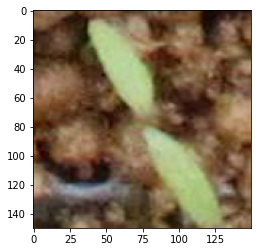

In [0]:

from PIL import Image

#img_path2= "/content/drive/My Drive/cluster0312/hakidamegiku1/hakidamegiku_IMG_1524_10.JPG"
img_path2= "/content/drive/My Drive/cluster0312/hosoaogeitou1/hosoaogeitou_IMG_1526_1.JPG"
#↑判定させたいpathを指定する

input_size=150

img = Image.open(img_path2).convert('RGB') 
img = img.resize((input_size,input_size))
x = np.array(img, dtype=np.float32)
x = x / 255.
plt.imshow(x)
print("以下の画像を判定します")

In [0]:

y=np.expand_dims(x,axis=0)
pred = model.predict(y, batch_size=1, verbose=0)

#最大の確率のものを抜き出す
pred_label = np.argmax(pred)
print(pred_label)

#もし各可能性を行列で見たい場合
print(pred)



2
[[2.61790115e-06 5.53098154e-08 4.28322405e-01 1.12384056e-04
  2.60415491e-05 6.21517870e-07 2.93228379e-03 2.06607856e-05
  2.83485022e-03 4.08698853e-08 1.14452960e-04 2.66508300e-06
  1.12655506e-01 6.03325498e-05 1.40799428e-04 2.46311575e-01
  2.05960065e-01 4.94970163e-06 4.97531495e-04 1.71659551e-07]]


この画像はhosoaogeitouです


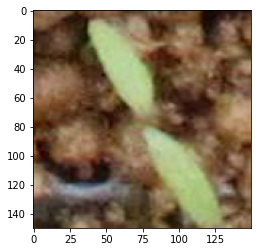

In [0]:
plt.imshow(x)
print("この画像は"+classes[pred_label]+"です")


In [34]:
'''
ここからtest
gradcamのための新しいモデル
以前の作り方だとgradcamで可視化するのが非常に困難
'''
#ここからファインチューニング+VGG+水増し。ここから実行してOK（VGG16をダウンロード）
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications import VGG16


input_size=150
#input_sizeは224,224までOK。

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(input_size,input_size, 3))
last = vgg_conv.output


vgg_conv.trainable = True

set_trainable = False
for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


mod = Flatten()(last)
mod = Dense(256, activation='relu')(mod)
#mod = Dropout(0.5)(mod)
preds = Dense(20, activation='softmax')(mod)

model = models.Model(vgg_conv.input, preds)

model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
'''
この書き方だとvgg16が１つの層にまとまらないのでblock5が取り出せる
参考URL
https://qiita.com/T_Tao/items/0e869e440067518b6b58#grad-cam%E3%81%AE%E5%AE%9F%E8%A3%85
'''

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

'\nこの書き方だとvgg16が１つの層にまとまらないのでblock5が取り出せる\n参考URL\nhttps://qiita.com/T_Tao/items/0e869e440067518b6b58#grad-cam%E3%81%AE%E5%AE%9F%E8%A3%85\n'

In [7]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image


#clsdir = "/content/deeplearning/weed_type"

clsdir = "/content/drive/My Drive/cluster0312"



datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            validation_split = 0.2,
            rescale=1./255
        )
#validation_splitでtrainとvalidationの比率を変更できる。


train_generator=datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
        )

validation_generator = datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
        )

Found 3129 images belonging to 20 classes.
Found 775 images belonging to 20 classes.


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

In [0]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [0]:
#モデルを保存するなら
model.save('weed_type.h1')
model.save_weights('weed_type.h5')
model.load_weights('weed_type.h5')


In [0]:
my_model = models.load_model('weed_type.h1') 
last_layer_name = 'block5_conv3'


In [25]:
from keras.preprocessing import image

# 画像のパスを取得
img_path = "/content/drive/My Drive/cluster0312/mameasagao1/mameasagao_IMG_4176_4.JPG"
img=image.load_img(img_path,target_size=(150,150))

# データの前処理
img = image.load_img(img_path, target_size=(150,150))

# xは形状が(224,224,3)のfloat32型のnumpy配列
x = image.img_to_array(img)/255.0

# この配列サイズが(1, 224, 224, 3)のバッチに変換するために次元を追加
x = np.expand_dims(x, axis=0)
preds = my_model.predict(x)
print(np.argmax(preds[0]))

10


(9, 9)


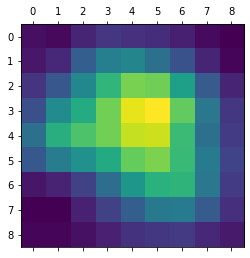

In [29]:
from keras import backend as K 
import matplotlib.pyplot as plt

# 予測ベクトルのAudi-a3エントリ
output = my_model.output[:,np.argmax(preds[0])]

# 最後の層であるblock5_conv3の出力特徴マップ
last_conv_layer = my_model.get_layer(last_layer_name)

# block5_conv3の出力特徴マップでの「ある」クラス勾配
grads = K.gradients(output,last_conv_layer.output)[0]


# 各エントリは特定の特徴マップの平均強度
pooled_grads = K.mean(grads,axis=(0,1,2))

#Audi-a3の画像に基づいてpooled_gradsとconv2d_15の出力マップの値にアクセスするための関数
iterate = K.function([my_model.input], [pooled_grads, last_conv_layer.output[0]])

# 2つの値をNumpy配列で取得
pooled_grads_value, conv_layer_output_value = iterate([x])

# 「ある」クラスに関する「このチャネルの重要度」を特徴マップ配列の各チャネルに掛ける
for i in range(pooled_grads_value.shape[0]):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

# 最終的な特徴マップのチャネルごとの平均値がクラスの活性化のヒートマップ
heatmap = np.mean(conv_layer_output_value,axis=-1 )

# ヒートマップの後処理
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [32]:
import cv2

# cv2を使って画像読み込み
img = cv2.imread(img_path)
# 元画像と同じサイズになるようにヒートマップのサイズを変更
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# ヒートマップをRGBに変換
heatmap = np.uint8(255 * heatmap)
# ヒートマップをもとの画像に適応
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4はヒートマップの強度係数(もうちょっと強くしてもいい)
superimporsed_img = heatmap * 0.4 + img
# 画像を保存
cv2.imwrite('保存したい名前.jpg',superimporsed_img)

True

<function matplotlib.pyplot.show>

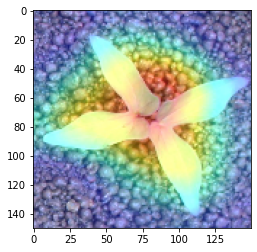

In [33]:
img = image.load_img('保存したい名前.jpg', target_size=(input_size,input_size))
img_tensor = image.img_to_array(img)
img_tensor /= 255.
plt.imshow(img_tensor)
plt.show